In [3]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pip install seaborn==0.11.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 283 kB 2.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
sns.__version__

'0.11.0'

In [5]:
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/cov-S-aligned-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"

In [6]:
def get_perturbation_output(perturbation_processed_output_dir):
    perturbation_output_files = os.listdir(perturbation_processed_output_dir)
    print(f"Number of perturbation output files = {len(perturbation_output_files)}")

    perturbed_output_dfs = []
    for perturbation_output_file in perturbation_output_files:
        df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
        orig_seq_df = df[df["orig_token"] == df["new_token"]]
        orig_pred_val = orig_seq_df[human_label].values[0]
        df[pred_diff_col] = df[human_label] - orig_pred_val
        df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
        perturbed_output_dfs.append(df)
    return pd.concat(perturbed_output_dfs)

In [7]:
perturbed_output_df = get_perturbation_output(perturbation_processed_output_dir)
print(f"perturbed_output_df shape = {perturbed_output_df.shape}")

Number of perturbation output files = 94
perturbed_output_df shape = (2978369, 15)



#### WIV04 reference sequence

In [8]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniref/aligned/coronaviridae_s_uniref90_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniref90_id"] == "WIV04"]
wiv04_df.head()

,uniref90_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens


In [9]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
wiv04_aligned_seq

'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [10]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = int(pos)
        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_seq_pos"].astype("Int64")

In [11]:
perturbed_output_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos
0,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,K,2234,Q,0.000000,0.000000,1149
1,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,F,2233,H,0.000000,0.000000,1148
2,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,E,2235,T,0.000000,0.000000,1150
3,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,E,1787,U,0.000000,0.000000,780
4,0.000281,0.004669,0.079043,0.002242,0.004940,0.005237,0.771312,0.132277,UniRef90_A0A8B1JBP8,Human,F,130,M,-0.008243,0.008243,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31521,0.004629,0.006263,0.015908,0.006993,0.003021,0.000424,0.866795,0.095968,UniRef90_A0A8B6RKY6,Human,S,1669,F,0.000000,0.000000,673
31522,0.004629,0.006263,0.015908,0.006993,0.003021,0.000424,0.866795,0.095968,UniRef90_A0A8B6RKY6,Human,K,2408,Z,0.000000,0.000000,1266
31523,0.003971,0.006221,0.015743,0.006036,0.002833,0.000422,0.876217,0.088556,UniRef90_A0A8B6RKY6,Human,A,896,Y,0.009422,0.009422,363
31524,0.004629,0.006263,0.015908,0.006993,0.003021,0.000424,0.866795,0.095968,UniRef90_A0A8B6RKY6,Human,V,1788,N,0.000000,0.000000,781


In [12]:
perturbed_output_df = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isna()]

In [13]:
perturbed_output_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos
0,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,K,2234,Q,0.000000,0.000000,1149
1,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,F,2233,H,0.000000,0.000000,1148
2,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,E,2235,T,0.000000,0.000000,1150
3,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,E,1787,U,0.000000,0.000000,780
4,0.000281,0.004669,0.079043,0.002242,0.004940,0.005237,0.771312,0.132277,UniRef90_A0A8B1JBP8,Human,F,130,M,-0.008243,0.008243,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31521,0.004629,0.006263,0.015908,0.006993,0.003021,0.000424,0.866795,0.095968,UniRef90_A0A8B6RKY6,Human,S,1669,F,0.000000,0.000000,673
31522,0.004629,0.006263,0.015908,0.006993,0.003021,0.000424,0.866795,0.095968,UniRef90_A0A8B6RKY6,Human,K,2408,Z,0.000000,0.000000,1266
31523,0.003971,0.006221,0.015743,0.006036,0.002833,0.000422,0.876217,0.088556,UniRef90_A0A8B6RKY6,Human,A,896,Y,0.009422,0.009422,363
31524,0.004629,0.006263,0.015908,0.006993,0.003021,0.000424,0.866795,0.095968,UniRef90_A0A8B6RKY6,Human,V,1788,N,0.000000,0.000000,781


#### Distribution of Human class difference

<Figure size 432x288 with 0 Axes>

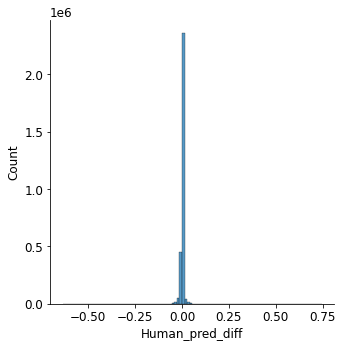

,start,end,count,percentage
0,-0.635250,-0.566258,5,0.000169
1,-0.566258,-0.497265,36,0.001219
2,-0.497265,-0.428273,86,0.002912
3,-0.428273,-0.359281,120,0.004064
4,-0.359281,-0.290288,177,0.005994
5,-0.290288,-0.221296,210,0.007112
6,-0.221296,-0.152304,404,0.013681
7,-0.152304,-0.083311,1944,0.065833
8,-0.083311,-0.014319,76120,2.577788
9,-0.014319,0.054673,2869572,97.177471


In [14]:
plt.clf()
#plt.rcParams['xtick.labelsize'] = 12
#plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["figure.figsize"] = 24, 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams.update({'font.size': 12})
sns.displot(perturbed_output_df["Human_pred_diff"], bins=100)
plt.show()

n_bins = 20
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(perturbed_output_df[pred_diff_col], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})
    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

In [15]:
selected_df = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
print(f"Number of sequences with abs_{pred_diff_col} >= 0.1: {selected_df.shape[0]} ({selected_df.shape[0]/perturbed_output_df.shape[0]*100})")

Number of sequences with abs_Human_pred_diff >= 0.1: 3139 (0.10630159513349334)


<Figure size 1728x864 with 0 Axes>

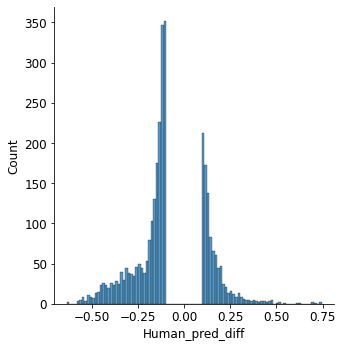

,start,end,count,percentage
0,-0.635250,-0.566258,5,0.000169
1,-0.566258,-0.497265,36,0.001219
2,-0.497265,-0.428273,86,0.002912
3,-0.428273,-0.359281,120,0.004064
4,-0.359281,-0.290288,177,0.005994
5,-0.290288,-0.221296,210,0.007112
6,-0.221296,-0.152304,404,0.013681
7,-0.152304,-0.083311,1100,0.037251
8,-0.083311,-0.014319,0,0.000000
9,-0.014319,0.054673,0,0.000000


In [16]:
plt.clf()
#plt.rcParams['xtick.labelsize'] = 12
#plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["figure.figsize"] = 36, 24
#plt.rcParams["xtick.labelsize"] = 12
#plt.rcParams["ytick.labelsize"] = 12
plt.rcParams.update({'font.size': 12})
sns.displot(selected_df["Human_pred_diff"], bins=100)
plt.show()

n_bins = 20
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(selected_df[pred_diff_col], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})
    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

### Known Mutations

In [17]:
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","input/data/coronaviridae/20240313/wiv04/s_mutations.csv")
s_mutations_df = pd.read_csv(s_mutations_file_path)
s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] + s_mutations_df["pos"].astype("str") + s_mutations_df["new_token"]
s_mutations_df.head(15)

,orig_token,pos,new_token,perturbation_id
0,D,614,G,D614G
1,S,943,P,S943P
2,E,484,K,E484K
3,N,501,Y,N501Y
4,L,452,R,L452R
5,Q,677,P,Q677P
6,Q,677,H,Q677H
7,P,681,H,P681H
8,E,484,Q,E484Q
9,K,417,N,K417N


In [18]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)
known_mutations_df = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(s_mutations_df["perturbation_id"])]
known_mutations_df

/tmp/ipykernel_280368/4074601110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)


,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,perturbation_id
8764,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,N,1399,Y,0.000000,0.000000,501,N501Y
8979,0.000210,0.004199,0.083298,0.001766,0.003963,0.005643,0.775784,0.125137,UniRef90_A0A8B1JBP8,Human,L,1243,R,-0.003771,0.003771,452,L452R
10138,0.000213,0.004282,0.076614,0.001703,0.003918,0.004942,0.792228,0.116101,UniRef90_A0A8B1JBP8,Human,S,1276,N,0.012674,0.012674,477,S477N
21915,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,S,2004,P,0.000000,0.000000,943,S943P
24205,0.000216,0.004125,0.082933,0.001825,0.003931,0.005560,0.774743,0.126667,UniRef90_A0A8B1JBP8,Human,S,1276,G,-0.004812,0.004812,477,S477G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17527,0.004689,0.006354,0.016217,0.007143,0.003128,0.000438,0.863578,0.098454,UniRef90_A0A8B6RKY6,Human,S,1276,G,-0.003217,0.003217,477,S477G
21238,0.004629,0.006263,0.015908,0.006993,0.003021,0.000424,0.866795,0.095968,UniRef90_A0A8B6RKY6,Human,N,1399,Y,0.000000,0.000000,501,N501Y
21309,0.004629,0.006263,0.015908,0.006993,0.003021,0.000424,0.866795,0.095968,UniRef90_A0A8B6RKY6,Human,Q,1673,H,0.000000,0.000000,677,Q677H
21366,0.004733,0.006586,0.014753,0.006718,0.003153,0.000385,0.873941,0.089730,UniRef90_A0A8B6RKY6,Human,S,1276,N,0.007146,0.007146,477,S477N


In [19]:
known_mutations_stats = known_mutations_df[["uniref90_id", "perturbation_id"]].groupby("perturbation_id").count().reset_index()
known_mutations_stats.rename(columns={"uniref90_id": "n_unique_sequences"}, inplace=True)
known_mutations_stats["percentage"] = known_mutations_stats["n_unique_sequences"] / 94 * 100
known_mutations_stats["label"] = known_mutations_stats.apply(lambda x: f"{x['perturbation_id']} (n={x['n_unique_sequences']} | {format(x['percentage'], '.2f')}%)", axis=1)
known_mutations_stats

,perturbation_id,n_unique_sequences,percentage,label
0,D614G,2,2.127660,D614G (n=2 | 2.13%)
1,E484K,83,88.297872,E484K (n=83 | 88.30%)
2,E484Q,83,88.297872,E484Q (n=83 | 88.30%)
3,K417N,89,94.680851,K417N (n=89 | 94.68%)
4,K417T,89,94.680851,K417T (n=89 | 94.68%)
5,L452R,30,31.914894,L452R (n=30 | 31.91%)
6,N501Y,85,90.425532,N501Y (n=85 | 90.43%)
7,P681H,91,96.808511,P681H (n=91 | 96.81%)
8,Q677H,88,93.617021,Q677H (n=88 | 93.62%)
9,Q677P,88,93.617021,Q677P (n=88 | 93.62%)


In [20]:
s_mutations_df = s_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")
s_mutations_df

,orig_token,pos,new_token,perturbation_id,label
0,D,614,G,D614G,D614G (n=2 | 2.13%)
1,S,943,P,S943P,S943P (n=93 | 98.94%)
2,E,484,K,E484K,E484K (n=83 | 88.30%)
3,N,501,Y,N501Y,N501Y (n=85 | 90.43%)
4,L,452,R,L452R,L452R (n=30 | 31.91%)
5,Q,677,P,Q677P,Q677P (n=88 | 93.62%)
6,Q,677,H,Q677H,Q677H (n=88 | 93.62%)
7,P,681,H,P681H,P681H (n=91 | 96.81%)
8,E,484,Q,E484Q,E484Q (n=83 | 88.30%)
9,K,417,N,K417N,K417N (n=89 | 94.68%)


In [21]:
def get_distribution_df(df, orig_token, perturb_pos, perturbation_id, perturbation_id_label):
    print(f"Perturbation id = {perturbation_id}")
    # perturbation df
    perturbation_df = df[df["perturbation_id"] == perturbation_id].copy()
    perturbation_df.loc[:, "type"] = "perturbation"
    
    # not perturbation df: all other perturbations in all sequences
    non_perturbation_df = df[df["perturbation_id"] != perturbation_id].copy()
    non_perturbation_df.loc[:, "type"] = "all seq, all non-mutatn perturbatns"
    
    # all other perturbations in the same position in all sequences
    pos_non_perturbation_df = df[(df["perturb_seq_pos"] == perturb_pos) & 
                                 (df["perturbation_id"] != perturbation_id)].copy()
    pos_non_perturbation_df.loc[:, "type"] = "all seq, same pos non-mutatn perturbatns"
    
    # sequences with original token
    sequence_w_orig_token_df = df[(df["orig_token"] == orig_token) & (df["perturb_seq_pos"] == perturb_pos)].copy()
    sequence_w_orig_token_ids = list(sequence_w_orig_token_df["uniref90_id"].unique())
    
    # all other perturbations in sequences with original token
    swo_non_perturbation_df = non_perturbation_df[non_perturbation_df["uniref90_id"].isin(sequence_w_orig_token_ids)].copy()
    swo_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, all non-mutatn perturbatns"
    
    # all other perturbations in the same positions in sequences with the original token
    swo_pos_non_perturbation_df = sequence_w_orig_token_df[sequence_w_orig_token_df["perturbation_id"] != perturbation_id].copy()
    swo_pos_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, same pos non-mutat perturbatns"
    
#     print(f"perturbation = {perturbation_df.shape}")
#     print(f"all seq, all non-perturbations = {non_perturbation_df.shape}")
#     print(f"all seq, same pos non-perturbations = {pos_non_perturbation_df.shape}")
#     print(f"sequence_w_orig_token_df = {sequence_w_orig_token_df.shape}")
#     print(f"seq w/ orig token, all non-perturbations = {swo_non_perturbation_df.shape}")
#     print(f"seq w/ orig token, same pos non-perturbations = {swo_pos_non_perturbation_df.shape}")
    
    result_df = pd.concat([perturbation_df, non_perturbation_df, pos_non_perturbation_df, swo_non_perturbation_df, swo_pos_non_perturbation_df])
    return result_df

In [22]:
# plot_dfs = []
# sequence_w_orig_token_df = None
# for _, row in s_mutations_df.head(4).iterrows():
#     plot_dfs.append(get_distribution_df(perturbed_output_df, 
#                                         orig_token=row["orig_token"],
#                                         perturb_pos=row["pos"],
#                                         perturbation_id=row["perturbation_id"],
#                                         perturbation_id_label=row["label"]))
    

# plot_df = pd.concat(plot_dfs)
# print(plot_df.shape)


Perturbation id = D614G


/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Perturbation id = S943P


/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Perturbation id = E484K


/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Perturbation id = N501Y


/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Perturbation id = L452R


/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Perturbation id = Q677P


/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Perturbation id = Q677H


/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Perturbation id = P681H


/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Perturbation id = E484Q


/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


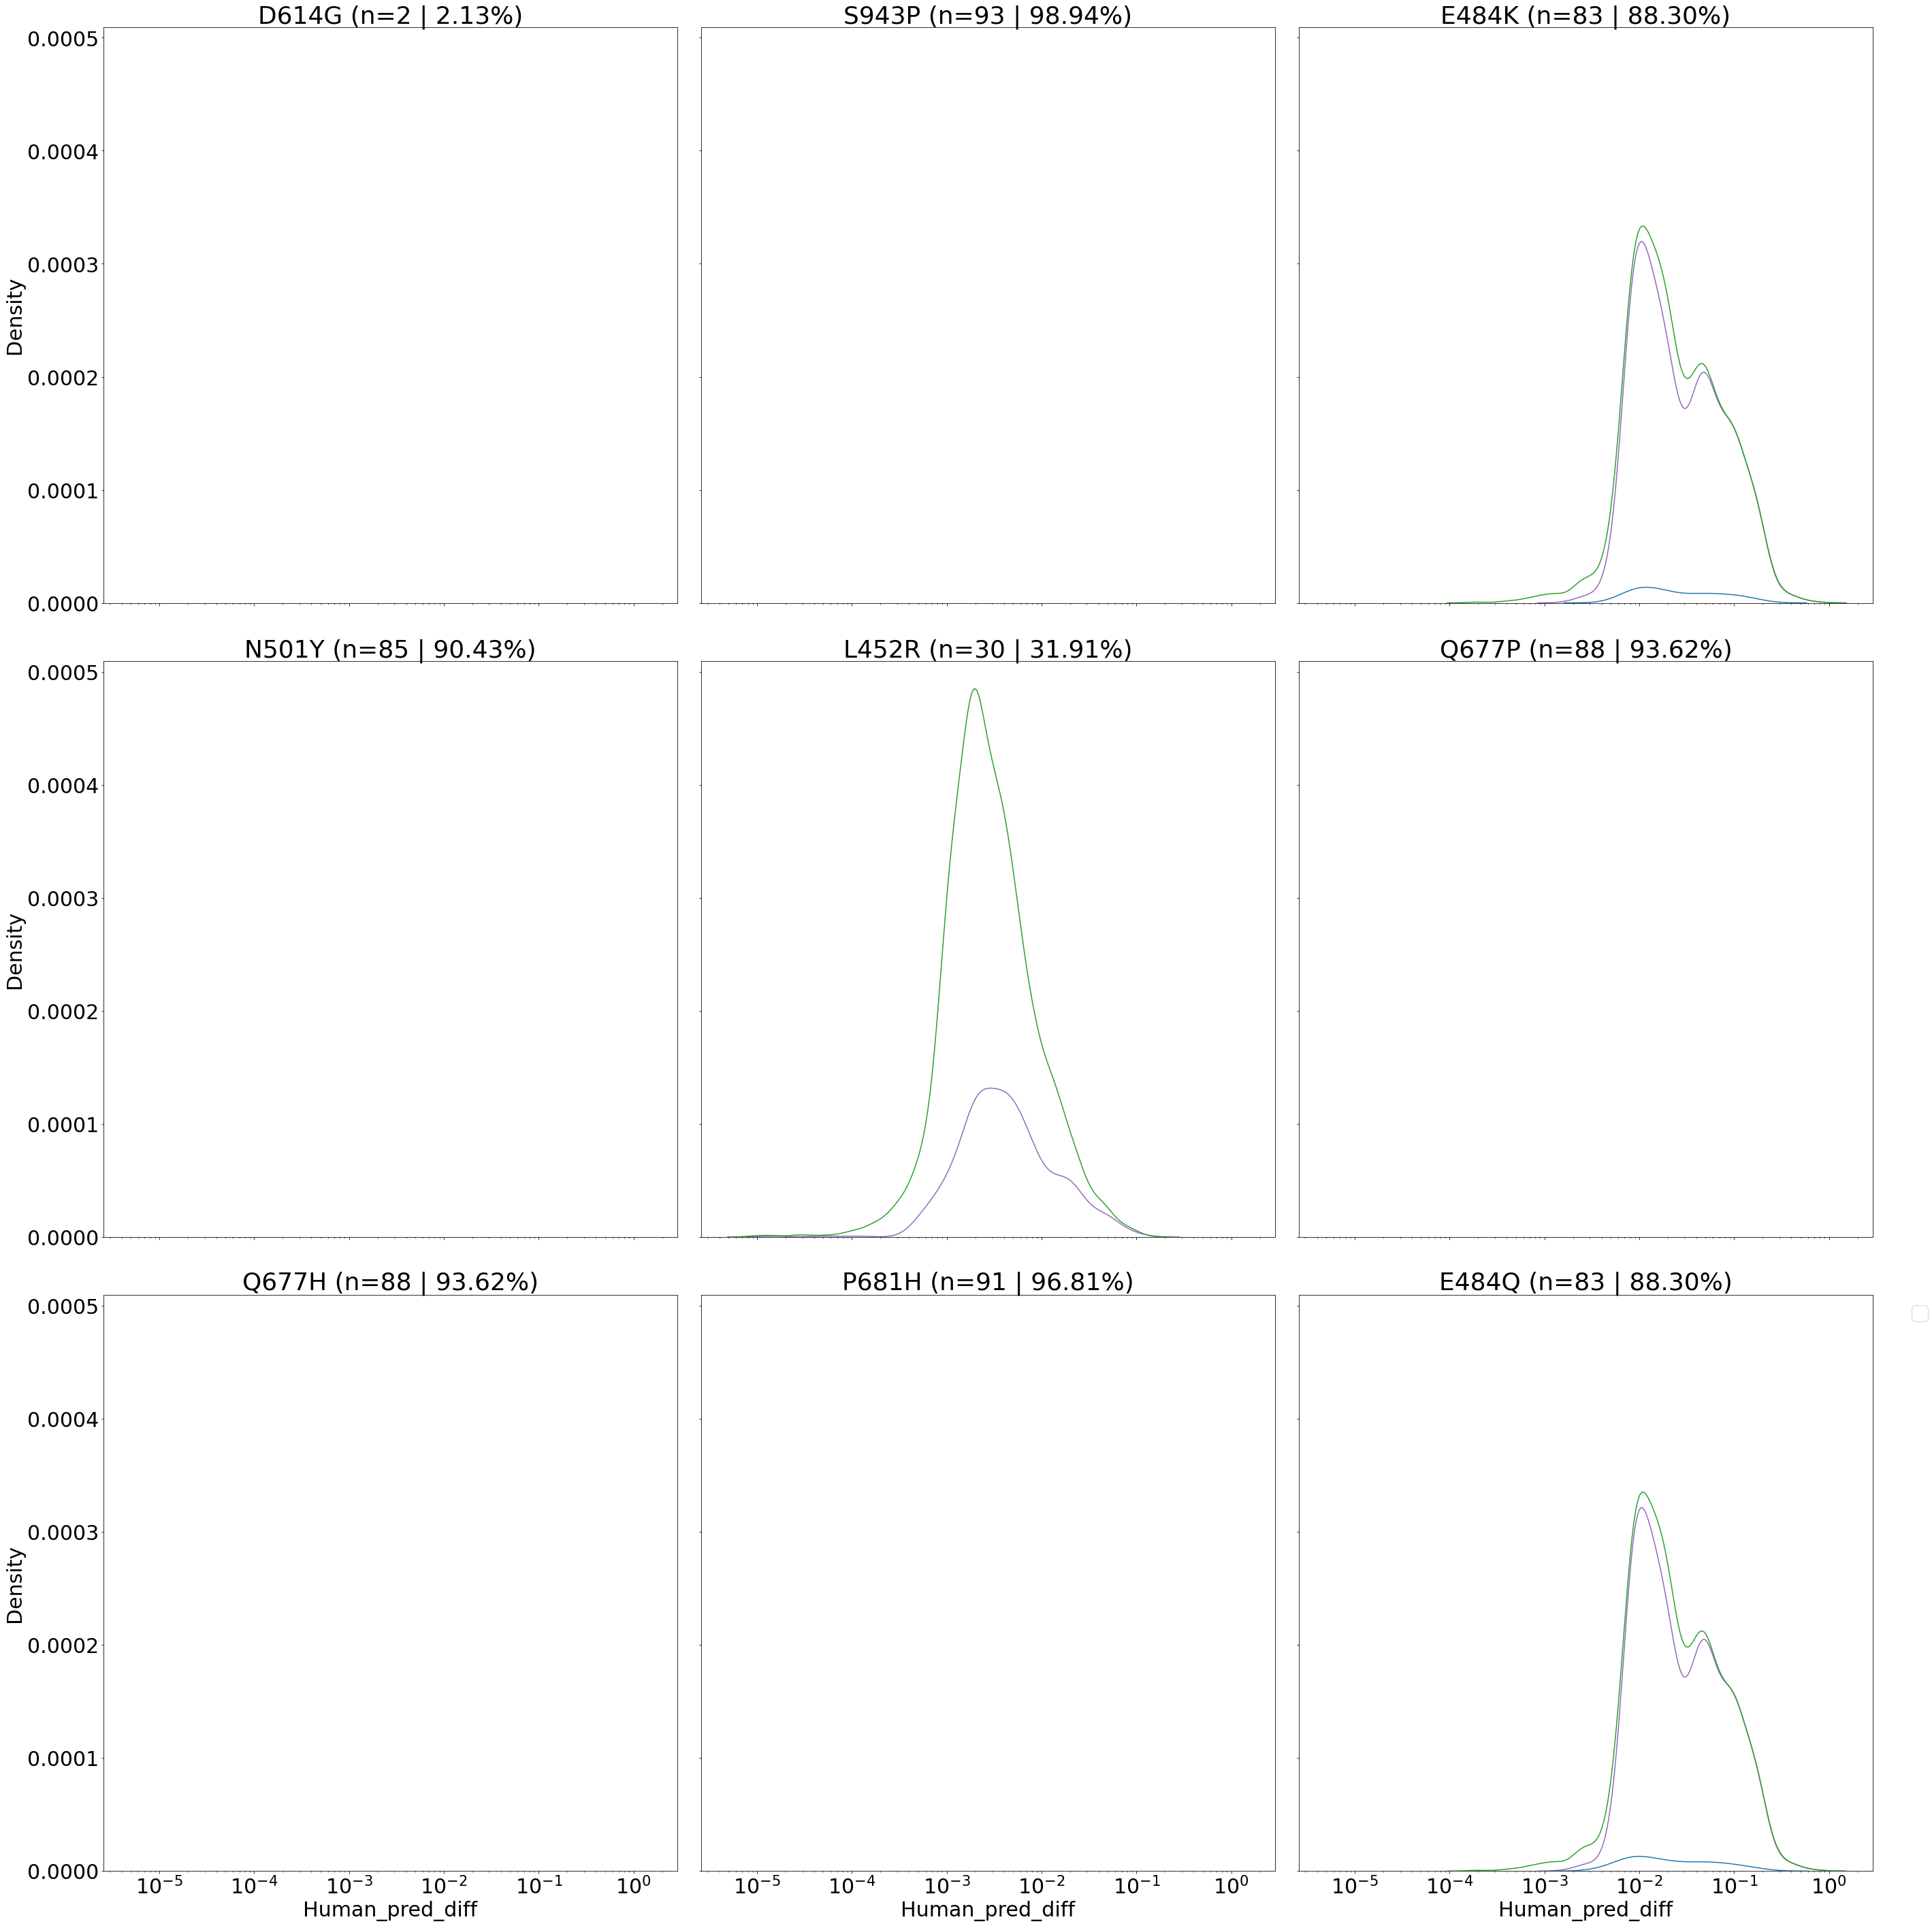

In [24]:
# plt.clf()
# plt.figure(figsize=(40, 20))
# plt.rcParams.update({'font.size': 20})
# plt.rcParams['xtick.labelsize'] = 20
# plt.rcParams['ytick.labelsize'] = 20
# plot_df.head(5)
# # g = sns.FacetGrid(plot_df, col="perturbation_id_label", col_wrap=2, margin_titles=True, height=4,)
# # g.map(sns.displot, x="Human_pred_diff", hue="type", kind="kde")
# sns.displot(data=plot_df, x="Human_pred_diff", hue="type", col="perturbation_id_label", col_wrap=2, kind="kde", height=4)
# plt.show()


plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(3, 3, figsize=(40, 40), sharex=True, sharey=True)

for i, ax in enumerate(axs.flatten()):
    row = s_mutations_df.loc[i, :]
    plot_df = get_distribution_df(perturbed_output_df, 
                                    orig_token=row["orig_token"],
                                    perturb_pos=row["pos"],
                                    perturbation_id=row["perturbation_id"],
                                    perturbation_id_label=row["label"])
    sns.kdeplot(data=plot_df, x="Human_pred_diff", hue="type", ax=ax, legend=False, log_scale=(True, False))
    ax.set_title(row["label"])
    del plot_df # delete the reference to release memory
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="30")
plt.tight_layout()
plt.show()


Perturbation id = D614G
Perturbation id = S943P
Perturbation id = E484K
Perturbation id = N501Y
Perturbation id = L452R
Perturbation id = Q677P
Perturbation id = Q677H
Perturbation id = P681H
Perturbation id = E484Q


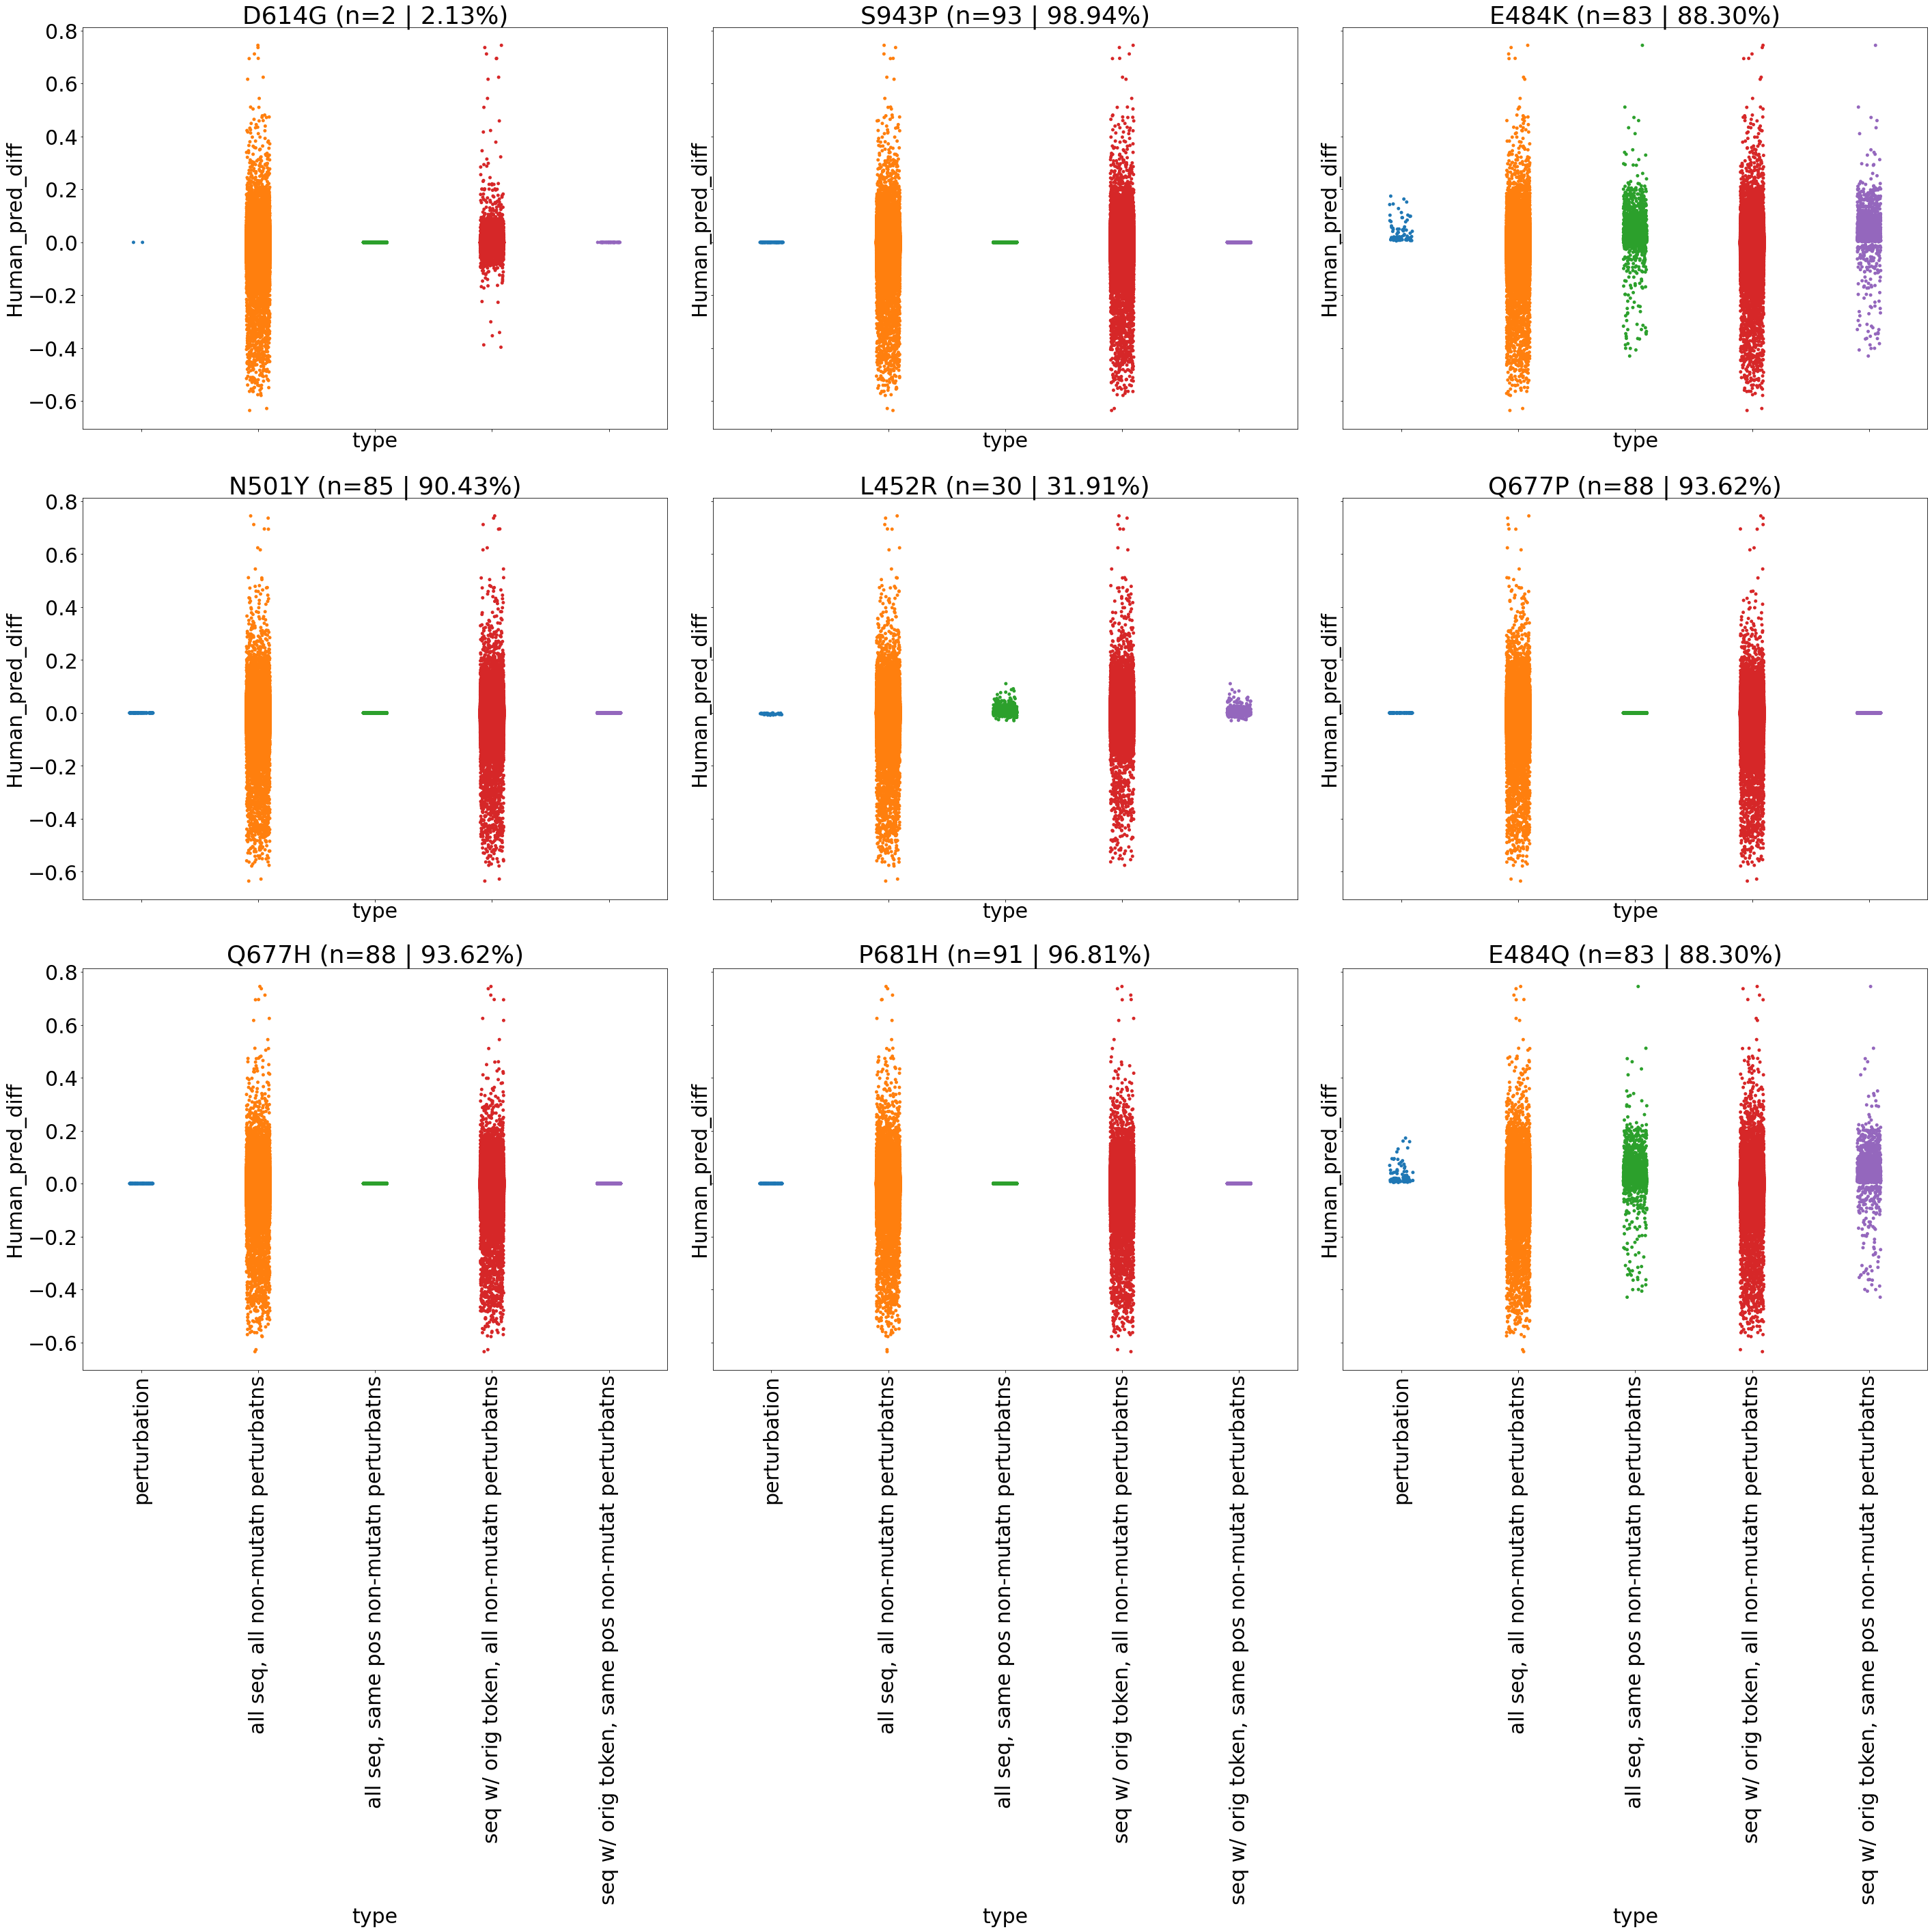

In [27]:
# plt.clf()
# plt.figure(figsize=(40, 20))
# plt.rcParams.update({'font.size': 20})
# plt.rcParams['xtick.labelsize'] = 20
# plt.rcParams['ytick.labelsize'] = 20
# plot_df.head(5)
# # g = sns.FacetGrid(plot_df, col="perturbation_id_label", col_wrap=2, margin_titles=True, height=4,)
# # g.map(sns.displot, x="Human_pred_diff", hue="type", kind="kde")
# sns.displot(data=plot_df, x="Human_pred_diff", hue="type", col="perturbation_id_label", col_wrap=2, kind="kde", height=4)
# plt.show()


plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(3, 3, figsize=(40, 40), sharex=True, sharey=True)

for i, ax in enumerate(axs.flatten()):
    row = s_mutations_df.loc[i, :]
    plot_df = get_distribution_df(perturbed_output_df, 
                                    orig_token=row["orig_token"],
                                    perturb_pos=row["pos"],
                                    perturbation_id=row["perturbation_id"],
                                    perturbation_id_label=row["label"])
    sns.stripplot(data=plot_df, y="Human_pred_diff", x="type", ax=ax)
    ax.set_title(row["label"])
    ax.tick_params(axis="x", labelrotation=90)
    plt.xticks(rotation=90)
    del plot_df # delete the reference to release memory
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="30")
plt.tight_layout()
plt.show()


<Figure size 2592x1728 with 0 Axes>

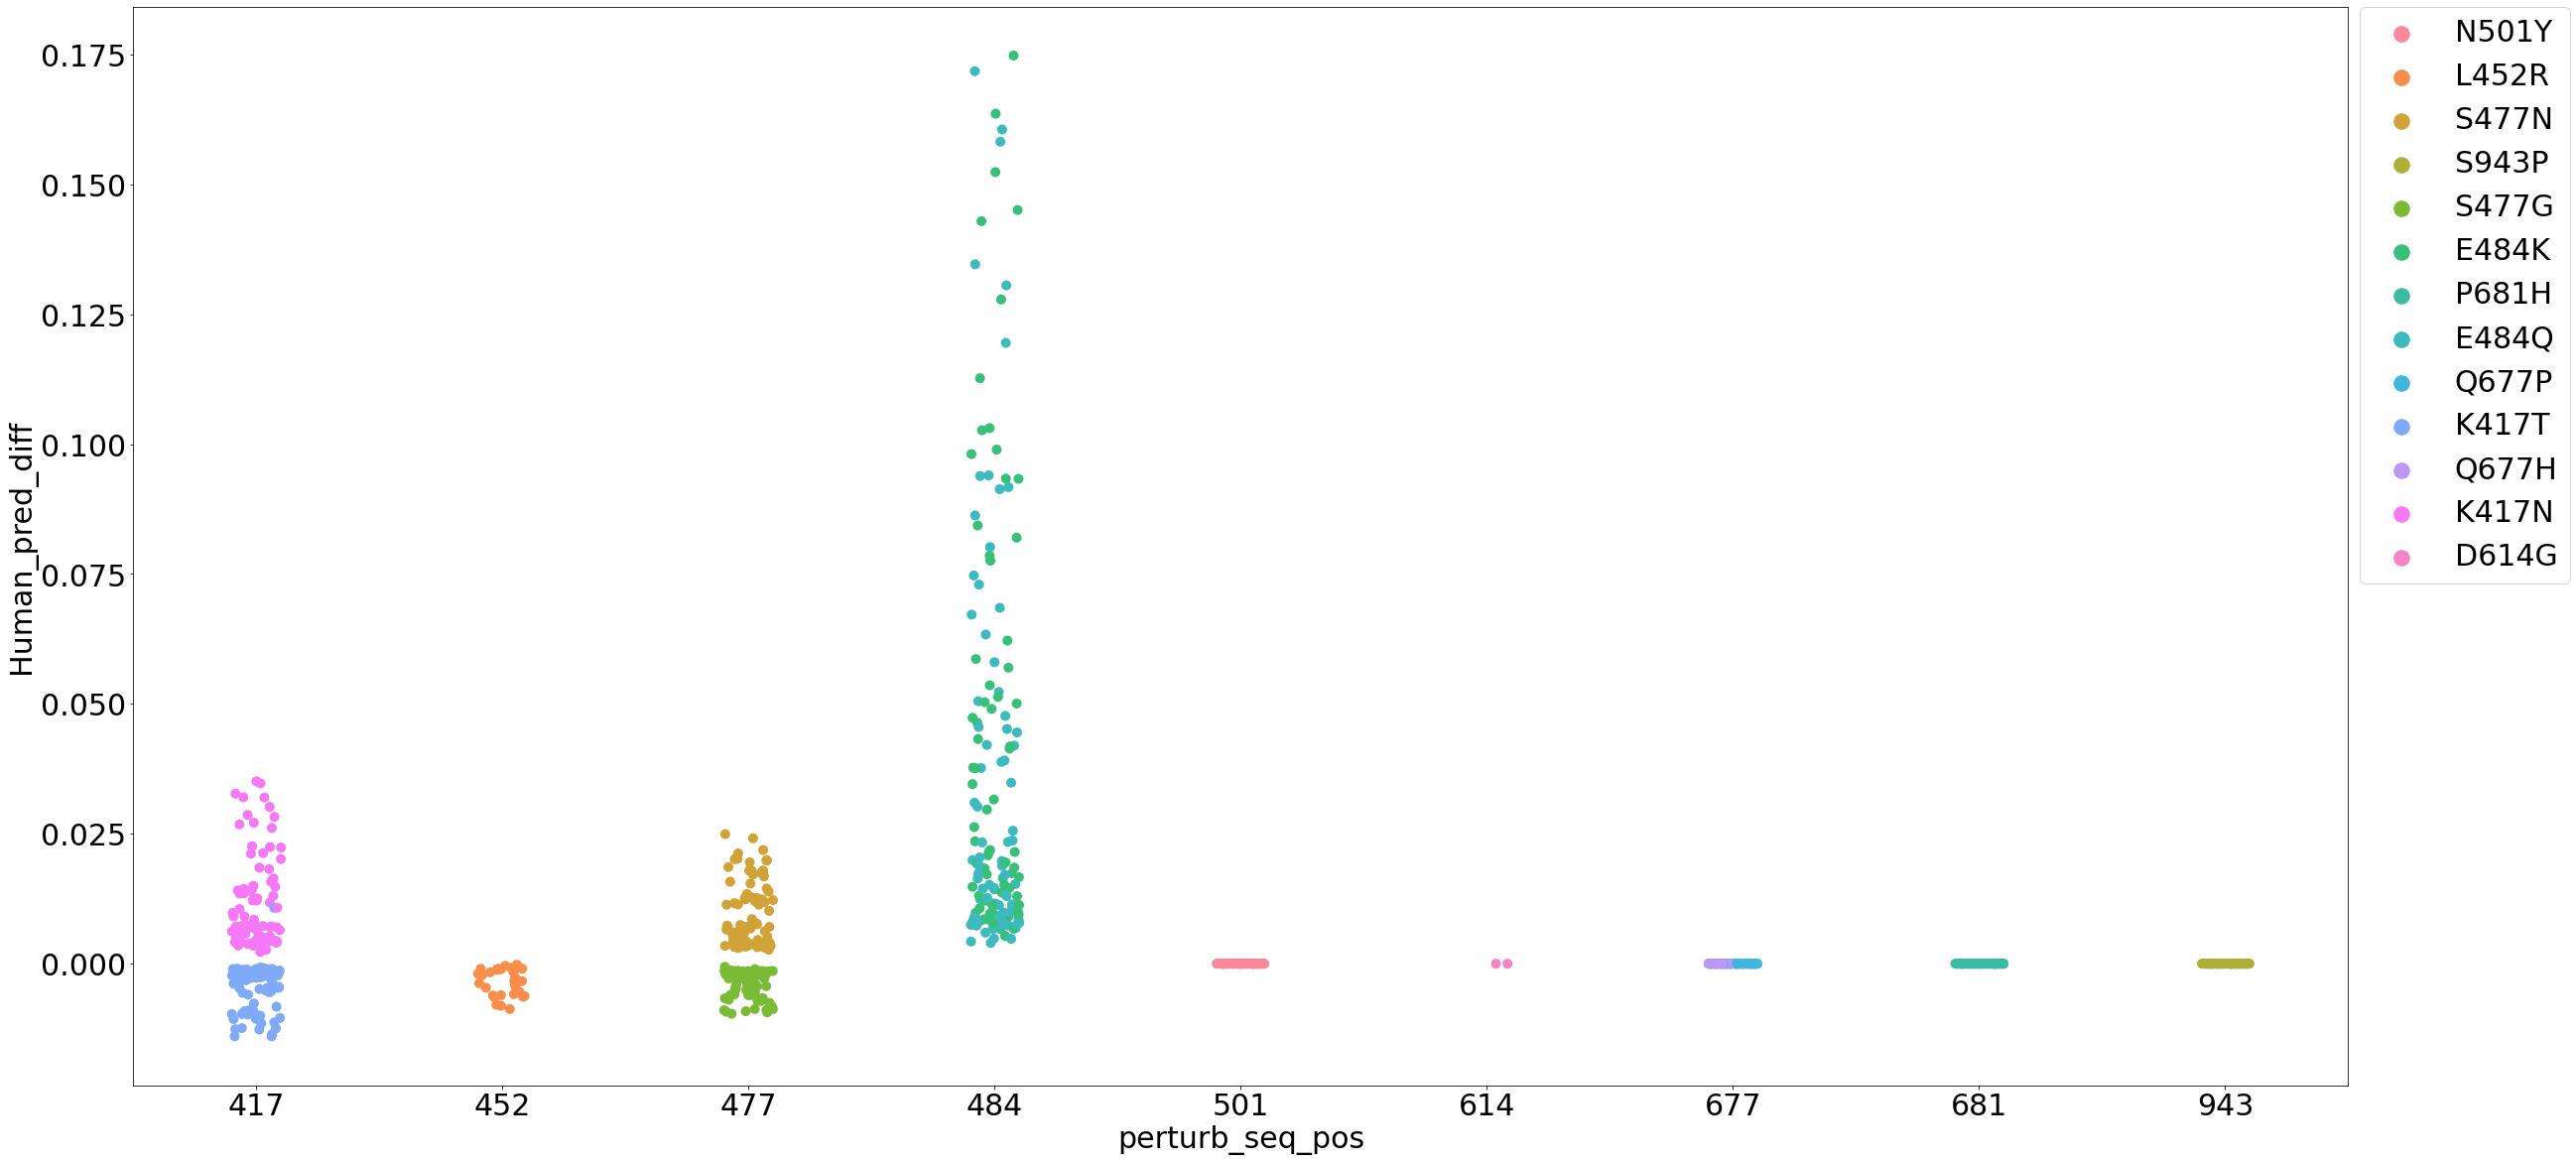

In [28]:
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.stripplot(data=known_mutations_df, x="perturb_seq_pos", y="Human_pred_diff", hue="perturbation_id", s=10)

x_mapping = {}
for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]

xytextcoords = [(-75, -75), (75, 75)]
# for _, row in known_mutations_df.iterrows():
#     if row["abs_Human_pred_diff"] > 0.01:
#         ax.annotate(text=row["perturbation_id"],
#                     xy=(x_mapping[str(row["perturb_seq_pos"])], row["Human_pred_diff"]), xycoords="data",
#                     xytext=xytextcoords[_ % 2], textcoords="offset points",
#                     arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
#                     bbox=dict(boxstyle="round", fc="w"))

plt.legend(bbox_to_anchor=(1.1, 1), borderaxespad=0, markerscale=2.)
#plt.xticks(rotation=90)

plt.show()

### Predicted important mutations

In [29]:
non_x_selected_df = selected_df[selected_df["new_token"] != "X"]
annotate_df_pos = non_x_selected_df.sort_values(by="Human_pred_diff", axis=0, ascending=False)[:5]
annotate_df_neg = non_x_selected_df.sort_values("Human_pred_diff", axis=0)[:5]
annotate_df = pd.concat([annotate_df_pos, annotate_df_neg])

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, '10': 9, '11': 10, '14': 11, '18': 12, '21': 13, '22': 14, '23': 15, '37': 16, '38': 17, '57': 18, '64': 19, '79': 20, '81': 21, '91': 22, '98': 23, '99': 24, '100': 25, '104': 26, '140': 27, '141': 28, '142': 29, '145': 30, '170': 31, '176': 32, '185': 33, '186': 34, '187': 35, '188': 36, '189': 37, '190': 38, '191': 39, '192': 40, '236': 41, '237': 42, '248': 43, '293': 44, '383': 45, '399': 46, '400': 47, '401': 48, '402': 49, '403': 50, '404': 51, '405': 52, '406': 53, '407': 54, '408': 55, '409': 56, '410': 57, '411': 58, '412': 59, '413': 60, '414': 61, '415': 62, '416': 63, '418': 64, '421': 65, '423': 66, '427': 67, '428': 68, '429': 69, '430': 70, '439': 71, '457': 72, '464': 73, '482': 74, '483': 75, '484': 76, '485': 77, '486': 78, '487': 79, '488': 80, '491': 81, '496': 82, '498': 83}


<Figure size 2592x1728 with 0 Axes>

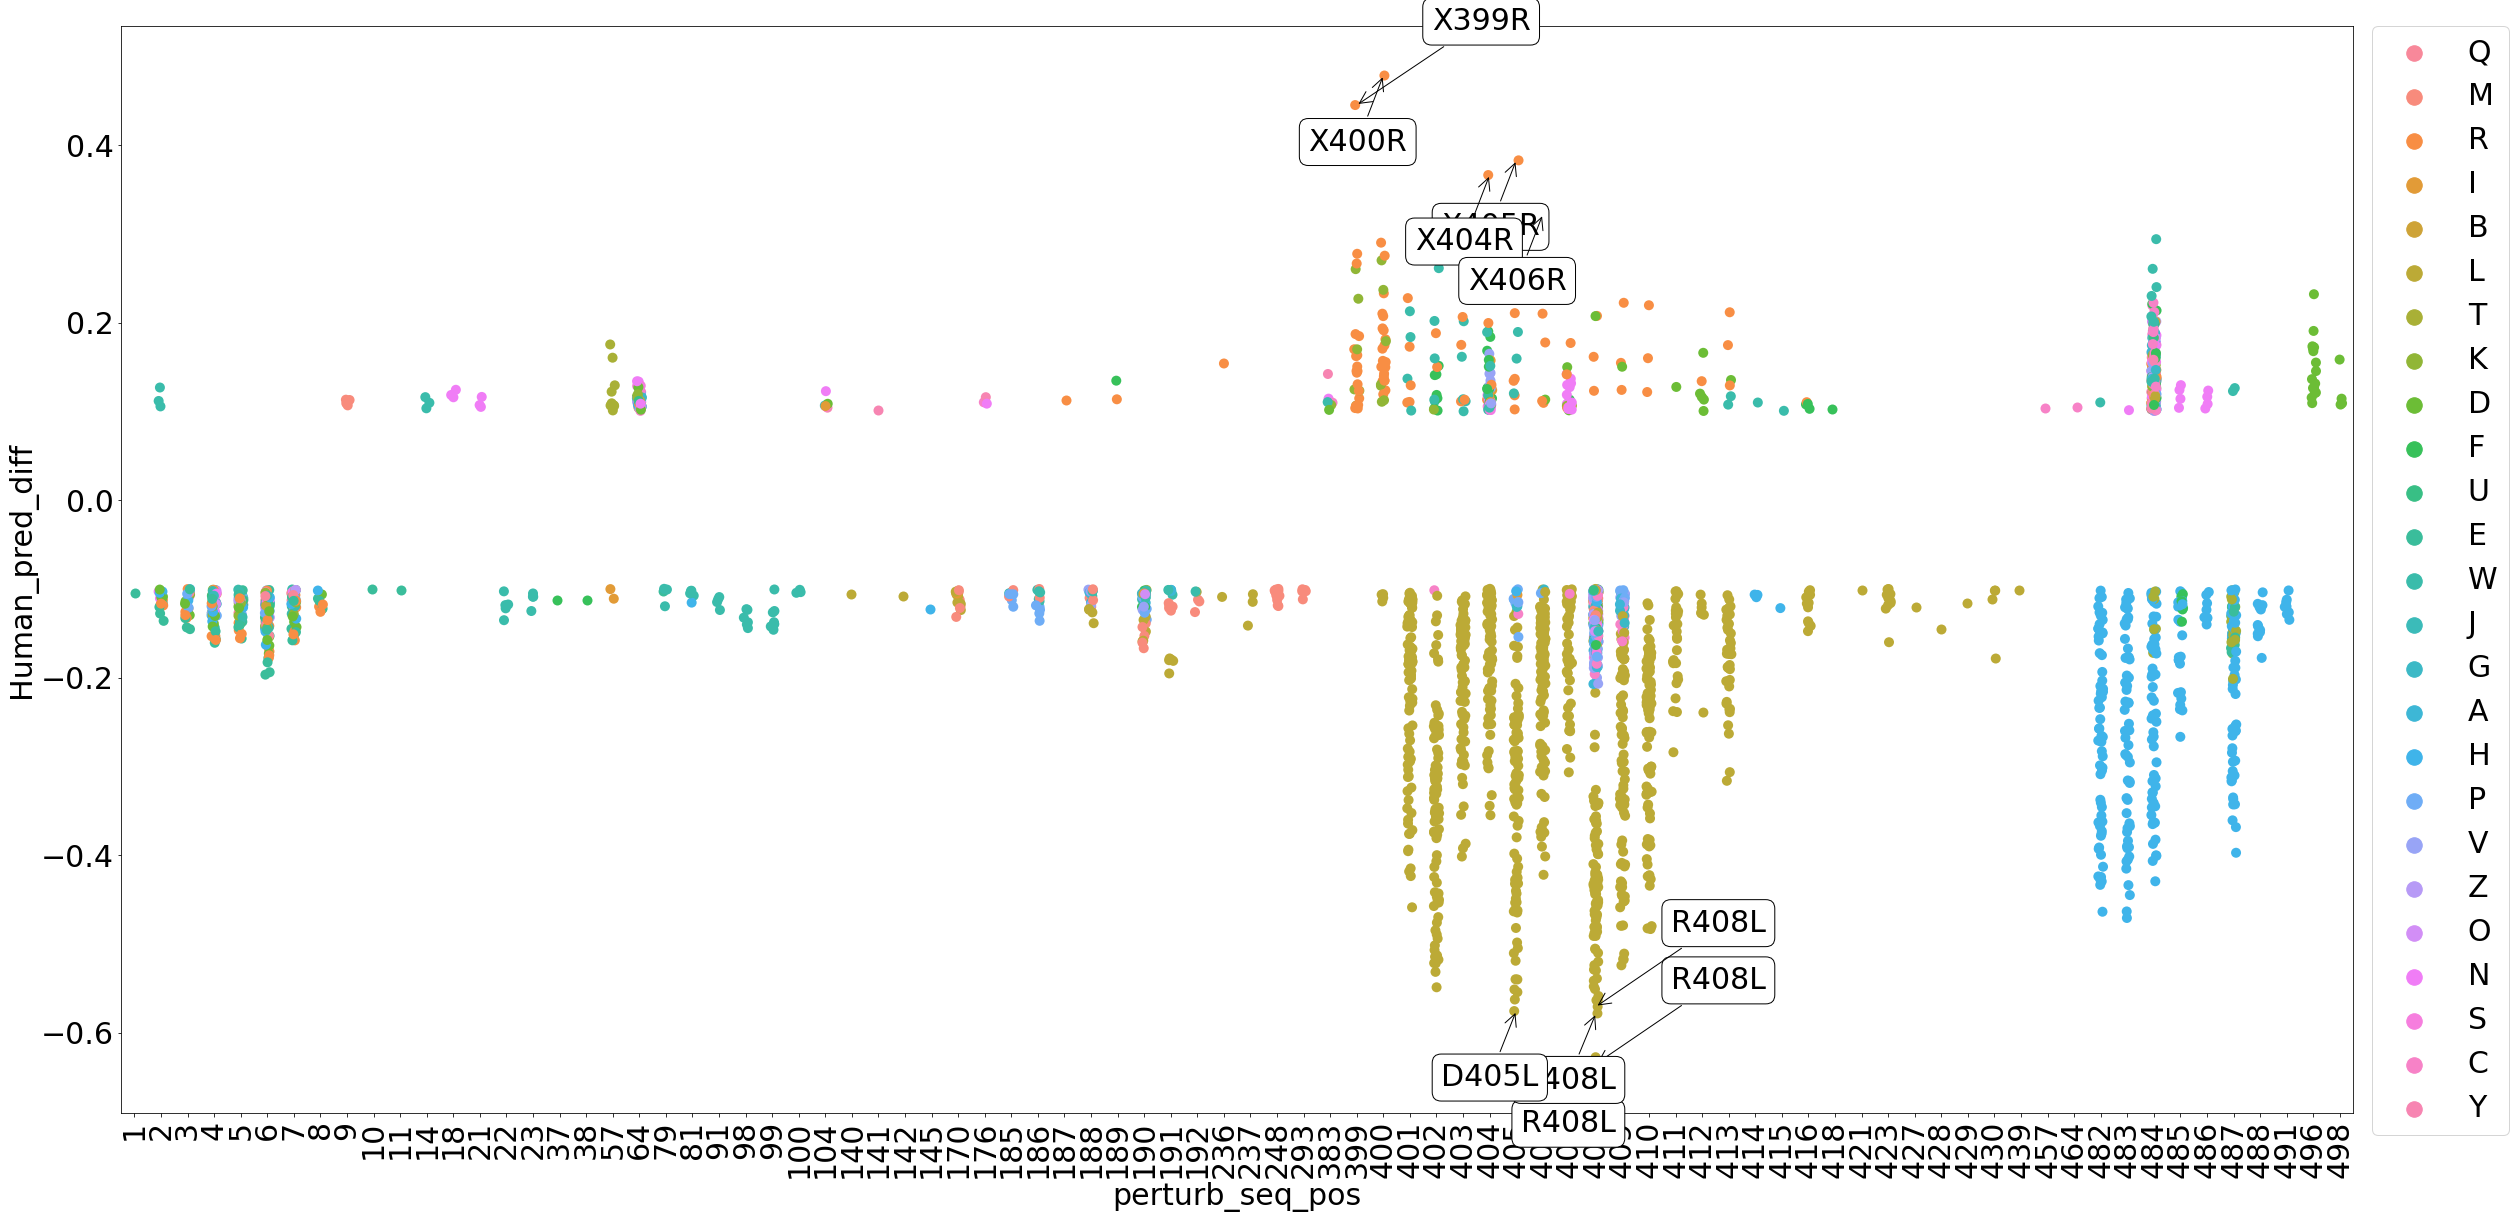

In [30]:
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.stripplot(data=non_x_selected_df, x="perturb_seq_pos", y="Human_pred_diff", hue="new_token", s=10)

x_mapping = {}
for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]
print(x_mapping)
xytextcoords = [(-75, -75), (75, 75)]
for _, row in annotate_df.iterrows():
    ax.annotate(text=f"{row['orig_token']}{str(row['perturb_seq_pos'])}{row['new_token']}",
                xy=(x_mapping[str(row["perturb_seq_pos"])], row["Human_pred_diff"]), xycoords="data",
                xytext=xytextcoords[_ % 2], textcoords="offset points",
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
                bbox=dict(boxstyle="round", fc="w"))
    
plt.legend(bbox_to_anchor=(1.07, 1), borderaxespad=0, markerscale=2.)
plt.xticks(rotation=90)

plt.show()

In [31]:
mutation_mean_diff = perturbed_output_df[["perturbation_id", "Human_pred_diff"]].groupby("perturbation_id").mean("Human_pred_diff").rename(columns={"Human_pred_diff": "mean_Human_pred_diff"})
mutation_mean_diff.reset_index(inplace=True)
mutation_mean_diff.sort_values("mean_Human_pred_diff", ascending=True)

,perturbation_id,mean_Human_pred_diff
23594,R408L,-0.438029
11788,I402L,-0.356960
3885,D405L,-0.345715
22044,Q409L,-0.295267
11813,I410L,-0.263974
...,...,...
43272,X400K,0.164138
43379,X404R,0.180191
43404,X405R,0.188933
43229,X399R,0.234506


In [32]:
mutation_mean_diff[mutation_mean_diff["mean_Human_pred_diff"] == 0]

,perturbation_id,mean_Human_pred_diff
0,A1015B,0.0
1,A1015C,0.0
2,A1015D,0.0
3,A1015E,0.0
4,A1015F,0.0
...,...,...
55408,Y917U,0.0
55409,Y917V,0.0
55410,Y917W,0.0
55411,Y917X,0.0


In [33]:
mutation_mean_diff_selected = mutation_mean_diff[(mutation_mean_diff["mean_Human_pred_diff"] > 0.1) | (mutation_mean_diff["mean_Human_pred_diff"] < -0.1)].sort_values("mean_Human_pred_diff", ascending=True)
mutation_mean_diff_selected

,perturbation_id,mean_Human_pred_diff
23594,R408L,-0.438029
11788,I402L,-0.356960
3885,D405L,-0.345715
22044,Q409L,-0.295267
11813,I410L,-0.263974
9283,G482H,-0.216844
30623,V401L,-0.215730
43623,X413L,-0.214577
5510,E406L,-0.213175
30769,V483H,-0.210279


In [34]:
perturbed_output_df[perturbed_output_df["perturbation_id"].isin(mutation_mean_diff_selected["perturbation_id"])]

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,perturbation_id
123,0.000377,0.004718,0.092867,0.003334,0.006327,0.007245,0.697861,0.187271,UniRef90_A0A8B1JBP8,Human,X,1077,L,-0.081694,0.081694,410,X410L
749,0.000151,0.004292,0.051254,0.000952,0.002566,0.002650,0.871518,0.066617,UniRef90_A0A8B1JBP8,Human,G,1301,X,0.091963,0.091963,485,G485X
3944,0.000755,0.006250,0.095210,0.006494,0.012986,0.009251,0.593693,0.275361,UniRef90_A0A8B1JBP8,Human,X,1087,L,-0.185862,0.185862,413,X413L
4678,0.000069,0.002430,0.057268,0.000531,0.001193,0.002853,0.885946,0.049708,UniRef90_A0A8B1JBP8,Human,X,1037,K,0.106391,0.106391,399,X399K
5225,0.000071,0.002442,0.060770,0.000563,0.001245,0.003121,0.878457,0.053330,UniRef90_A0A8B1JBP8,Human,X,1070,R,0.098902,0.098902,403,X403R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23474,0.025247,0.009928,0.023209,0.046769,0.014207,0.001014,0.579366,0.300261,UniRef90_A0A8B6RKY6,Human,G,1071,L,-0.287429,0.287429,404,G404L
24373,0.006286,0.005798,0.019302,0.011008,0.003708,0.000571,0.816054,0.137273,UniRef90_A0A8B6RKY6,Human,E,1300,H,-0.050741,0.050741,484,E484H
26102,0.002974,0.005905,0.010880,0.003688,0.002064,0.000245,0.918032,0.056213,UniRef90_A0A8B6RKY6,Human,V,1299,X,0.051237,0.051237,483,V483X
28769,0.007908,0.005871,0.020605,0.014281,0.004266,0.000637,0.788629,0.157804,UniRef90_A0A8B6RKY6,Human,G,1298,H,-0.078166,0.078166,482,G482H


<Figure size 2592x1728 with 0 Axes>

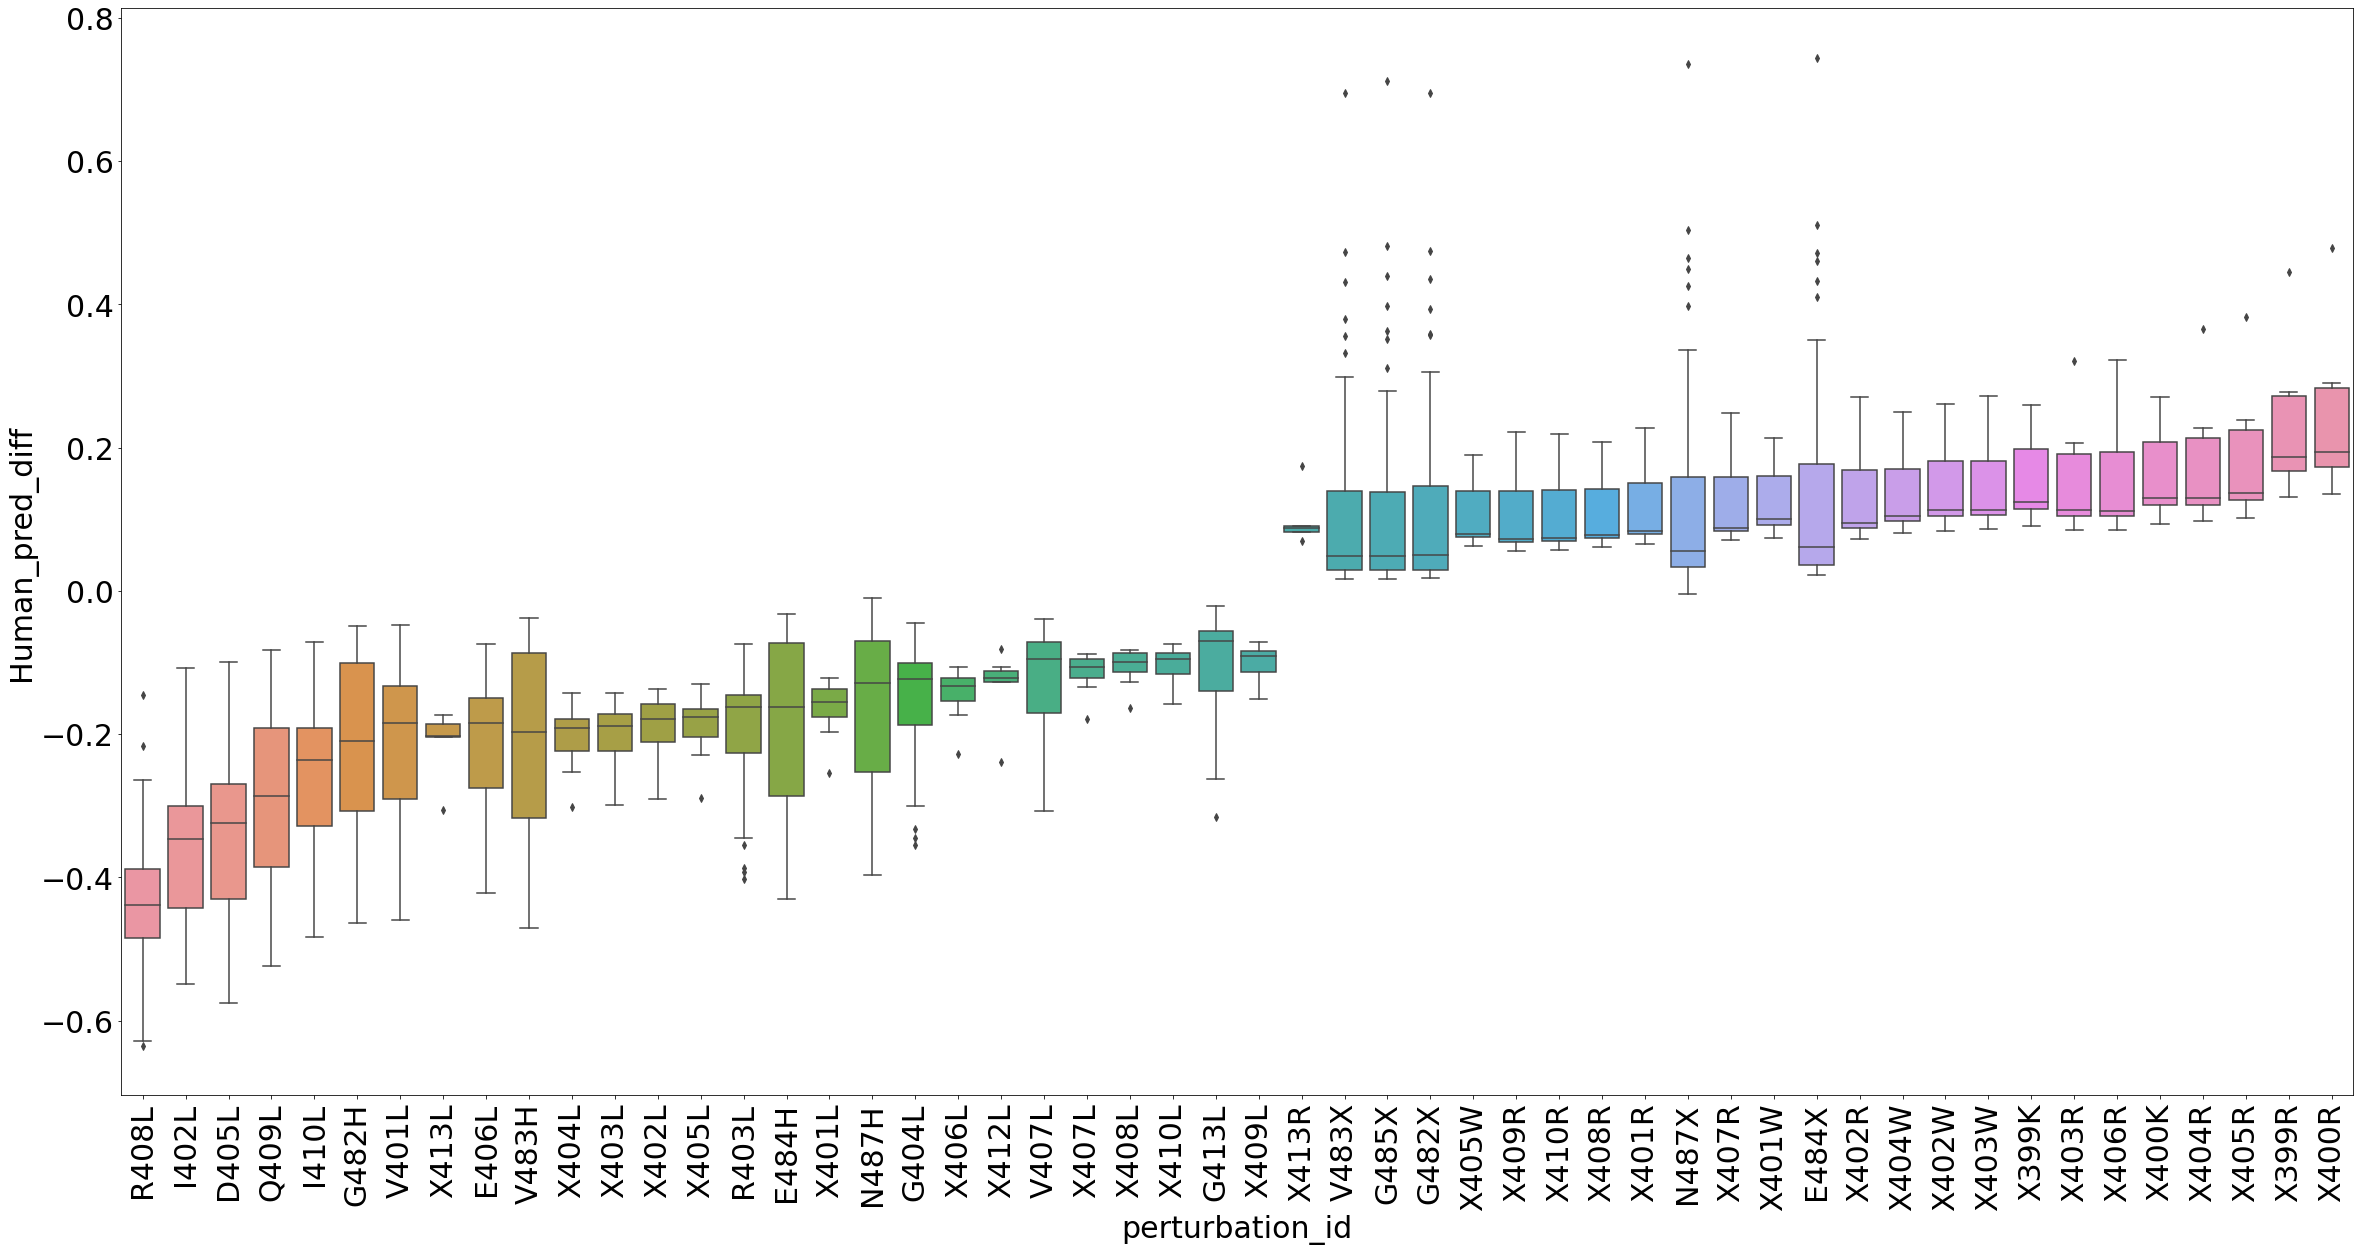

In [35]:
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

data = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(mutation_mean_diff_selected["perturbation_id"])][["perturbation_id", "Human_pred_diff"]]
ax = sns.boxplot(data=data, y="Human_pred_diff", x="perturbation_id", order=mutation_mean_diff_selected["perturbation_id"])
plt.xticks(rotation=90)
plt.show()